# MSc DATA SCIENCE DISSERTATION

# PREDICTING OBESITY FROM HEALTH BEHAVIORS IN ENGLAND

# Student Name: Gabriel Lucky Lotanna
# Student ID: 24070357
# Supervisor: Dhairya Kataria
# Date: February 2026
#
# Dataset: NHS Fingertips - Obesity & Health Behaviors (2020-2023)
# Source: https://fingertips.phe.org.uk/profile/obesity-physical-activity-nutrition
# Observations: 583 (147 Local Authorities × 4 years)


# 1. INSTALL & IMPORT LIBRARIES

In [50]:

# Install required packages
!pip install -q gdown shap

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# SHAP for explainability
import shap

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries loaded!")

✅ All libraries loaded!



# 2. LOAD DATASET FROM GOOGLE DRIVE

In [51]:
import gdown
# DATASET ACCESS:
# The dataset loads automatically from Google Drive
# No manual upload required
# Link is embedded in  this Cell

# Google Drive shareable link to merged dataset
DRIVE_LINK = "https://drive.google.com/file/d/1etKbMWDwCL3iVBoqVPWxFlwSu9Voy25c/view?usp=drive_link"

print("📥 Downloading dataset from Google Drive...")
gdown.download(DRIVE_LINK, 'dataset.csv', quiet=False, fuzzy=True)

# Load dataset
df = pd.read_csv('dataset.csv')

print(f"\n✅ Loaded: {df.shape[0]} observations, {df.shape[1]} variables")
print(f"📅 Years: {sorted(df['year'].unique())}")
print(f"🗺️  Local Authorities: {df['Area Name'].nunique()}")

# Display first rows
df.head()

📥 Downloading dataset from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1etKbMWDwCL3iVBoqVPWxFlwSu9Voy25c
To: /content/dataset.csv
100%|██████████| 34.1k/34.1k [00:00<00:00, 35.7MB/s]


✅ Loaded: 583 observations, 7 variables
📅 Years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
🗺️  Local Authorities: 147


,Area Code,Area Name,year,obesity_prevalence,physical_inactivity,smoking_prevalence,diet_5_a_day_pct
0,E06000001,Hartlepool,2020,34.63238,36.69158,16.8,32.01157
1,E06000002,Middlesbrough,2020,31.95300,31.64044,14.9,26.55877
2,E06000003,Redcar and Cleveland,2020,33.37358,28.02346,15.9,33.99259
3,E06000004,Stockton-on-Tees,2020,40.21633,23.13913,12.2,35.01736
4,E06000005,Darlington,2020,35.68230,27.57983,12.8,32.52256


In [52]:

# VERIFY DATASET LOADED CORRECTLY

print("="*70)
print("DATASET VERIFICATION")
print("="*70)

# Check shape
print(f"\nShape: {df.shape}")
print(f"   Expected: (583, 7)")
print(f"   Match: {df.shape == (583, 7)}")

# Check columns
expected_cols = ['Area Code', 'Area Name', 'year', 'obesity_prevalence',
                 'physical_inactivity', 'smoking_prevalence', 'diet_5_a_day_pct']
print(f"\nColumns: {list(df.columns)}")
print(f"   Match: {list(df.columns) == expected_cols}")

# Check data types
print(f"\nData types:")
print(df.dtypes)

# Check for missing values
missing = df.isnull().sum().sum()
print(f"\nMissing values: {missing}")
print(f"   Expected: 0")

# Sample statistics
print(f"\nObesity prevalence:")
print(f"   Mean: {df['obesity_prevalence'].mean():.2f}%")
print(f"   Min: {df['obesity_prevalence'].min():.2f}%")
print(f"   Max: {df['obesity_prevalence'].max():.2f}%")
print(f"   Expected Mean: ~26.53%")

# Check years
print(f"\nYears: {sorted(df['year'].unique())}")
print(f"   Expected: [2020, 2021, 2022, 2023]")

# Check number of LAs
print(f"\nLocal Authorities: {df['Area Name'].nunique()}")
print(f"   Expected: 147")

# Final verdict
print("\n" + "="*70)
if df.shape == (583, 7) and missing == 0:
    print("*** DATASET LOADED PERFECTLY! ***")
else:
    print("WARNING: THERE MAY BE AN ISSUE - CHECK ABOVE")
print("="*70)

# Display first few rows
print("\nFirst 5 rows:")
df.head()

DATASET VERIFICATION

Shape: (583, 7)
   Expected: (583, 7)
   Match: True

Columns: ['Area Code', 'Area Name', 'year', 'obesity_prevalence', 'physical_inactivity', 'smoking_prevalence', 'diet_5_a_day_pct']
   Match: True

Data types:
Area Code               object
Area Name               object
year                     int64
obesity_prevalence     float64
physical_inactivity    float64
smoking_prevalence     float64
diet_5_a_day_pct       float64
dtype: object

Missing values: 0
   Expected: 0

Obesity prevalence:
   Mean: 26.53%
   Min: 10.24%
   Max: 40.22%
   Expected Mean: ~26.53%

Years: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
   Expected: [2020, 2021, 2022, 2023]

Local Authorities: 147
   Expected: 147

*** DATASET LOADED PERFECTLY! ***

First 5 rows:


,Area Code,Area Name,year,obesity_prevalence,physical_inactivity,smoking_prevalence,diet_5_a_day_pct
0,E06000001,Hartlepool,2020,34.63238,36.69158,16.8,32.01157
1,E06000002,Middlesbrough,2020,31.95300,31.64044,14.9,26.55877
2,E06000003,Redcar and Cleveland,2020,33.37358,28.02346,15.9,33.99259
3,E06000004,Stockton-on-Tees,2020,40.21633,23.13913,12.2,35.01736
4,E06000005,Darlington,2020,35.68230,27.57983,12.8,32.52256



# 3. DESCRIPTIVE STATISTICS & DATA QUALITY CHECK

In [53]:

# This cell provides a comprehensive overview of your dataset
# including summary statistics and checks for any data quality issues

import numpy as np

print("="*70)
print("DESCRIPTIVE STATISTICS")
print("="*70)

# ---- Summary statistics for all numeric variables ----
# This shows count, mean, std, min, 25%, 50%, 75%, max for each variable
print("\n📊 Summary Statistics for All Variables:")
print(df[['obesity_prevalence', 'physical_inactivity',
          'smoking_prevalence', 'diet_5_a_day_pct']].describe().round(2))

# ---- Check for missing values ----
# Important to verify we have complete data before analysis
print("\n" + "="*70)
print("DATA COMPLETENESS CHECK")
print("="*70)

print("\n🔍 Missing Values by Column:")
missing = df.isnull().sum()
for col in df.columns:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    status = "✅" if missing_count == 0 else "⚠️"
    print(f"   {status} {col:25s}: {missing_count:3d} ({missing_pct:5.2f}%)")

total_missing = df.isnull().sum().sum()
if total_missing == 0:
    print(f"\n✅ EXCELLENT! No missing values found in any column!")
else:
    print(f"\n⚠️  Total missing values: {total_missing}")

# ---- Data distribution overview ----
print("\n" + "="*70)
print("VARIABLE RANGES")
print("="*70)

# Show min and max for each health indicator
for var in ['obesity_prevalence', 'physical_inactivity', 'smoking_prevalence', 'diet_5_a_day_pct']:
    print(f"\n{var}:")
    print(f"   Range: {df[var].min():.2f}% to {df[var].max():.2f}%")
    print(f"   Mean: {df[var].mean():.2f}%")
    print(f"   Median: {df[var].median():.2f}%")
    print(f"   Std Dev: {df[var].std():.2f}%")

# ---- Observations per year ----
print("\n" + "="*70)
print("TEMPORAL DISTRIBUTION")
print("="*70)

print("\n📅 Observations per Year:")
year_counts = df['year'].value_counts().sort_index()
for year, count in year_counts.items():
    print(f"   {year}: {count:3d} Local Authorities ({count/len(df)*100:.1f}%)")

# ---- Check data balance ----
la_counts = df['Area Name'].value_counts()
complete_las = (la_counts == 4).sum()
print(f"\n🗺️  Local Authorities with complete 4-year data: {complete_las}/{df['Area Name'].nunique()}")

print("\n✅ DESCRIPTIVE ANALYSIS COMPLETE!")

DESCRIPTIVE STATISTICS

📊 Summary Statistics for All Variables:
       obesity_prevalence  physical_inactivity  smoking_prevalence  \
count              583.00               583.00              583.00   
mean                26.53                23.56               11.99   
std                  5.84                 5.00                2.92   
min                 10.24                10.81                4.10   
25%                 22.83                20.02               10.10   
50%                 26.66                22.85               12.00   
75%                 30.48                27.19               13.70   
max                 40.22                38.37               21.80   

       diet_5_a_day_pct  
count            583.00  
mean              31.19  
std                5.62  
min               18.84  
25%               27.18  
50%               30.91  
75%               35.44  
max               49.52  

DATA COMPLETENESS CHECK

🔍 Missing Values by Column:
   ✅ Area Code   


# 4. EXPLORATORY DATA ANALYSIS - DISTRIBUTIONS & PATTERNS

EXPLORATORY DATA ANALYSIS - VISUAL EXPLORATION

📊 Creating distribution plots...
   ✓ Saved: 1_distributions_histograms.png


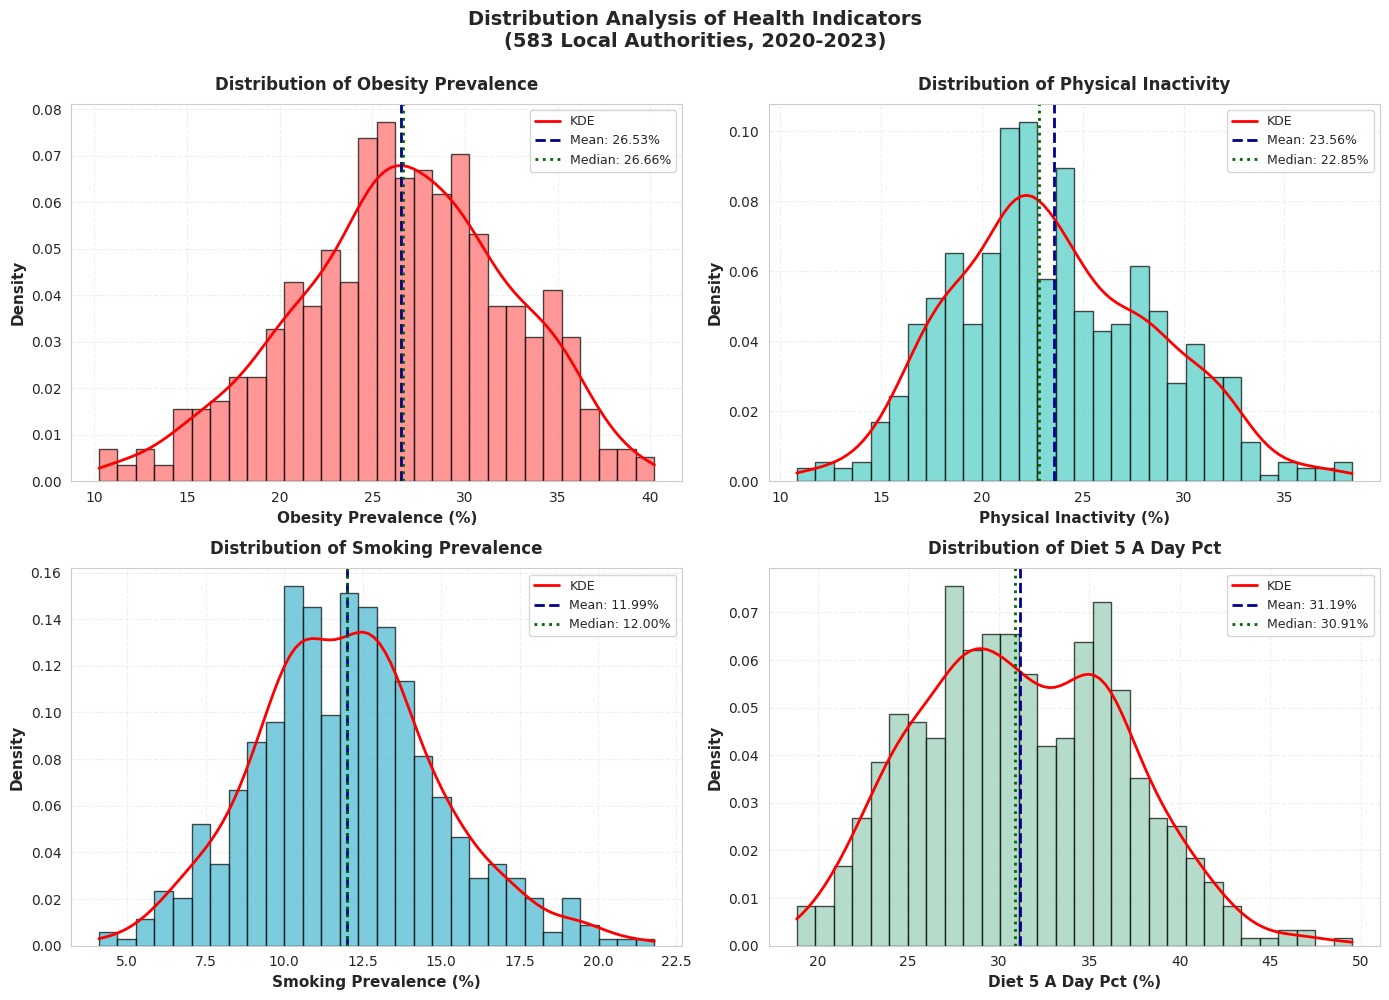

In [54]:

# EXPLORATORY DATA ANALYSIS - DISTRIBUTIONS & PATTERNS

# This cell provides comprehensive visual exploration of the dataset
# to understand data distributions, outliers, and temporal patterns
# BEFORE applying any machine learning models

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("="*70)
print("EXPLORATORY DATA ANALYSIS - VISUAL EXPLORATION")
print("="*70)

# Set professional plotting style
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'


# VISUALIZATION 1: DISTRIBUTION PLOTS (HISTOGRAMS)

# Purpose: Understand the shape and spread of each variable
# Shows: Whether data is normally distributed, skewed, or has outliers

print("\n📊 Creating distribution plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Variables to plot
variables = ['obesity_prevalence', 'physical_inactivity',
             'smoking_prevalence', 'diet_5_a_day_pct']

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, (var, color) in enumerate(zip(variables, colors)):
    ax = axes[i]

    # Create histogram with KDE (kernel density estimate - smooth curve)
    ax.hist(df[var], bins=30, alpha=0.7, color=color, edgecolor='black', density=True)

    # Add KDE curve
    from scipy import stats
    kde = stats.gaussian_kde(df[var])
    x_range = np.linspace(df[var].min(), df[var].max(), 100)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')

    # Add mean and median lines
    mean_val = df[var].mean()
    median_val = df[var].median()
    ax.axvline(mean_val, color='darkblue', linestyle='--', linewidth=2,
               label=f'Mean: {mean_val:.2f}%')
    ax.axvline(median_val, color='darkgreen', linestyle=':', linewidth=2,
               label=f'Median: {median_val:.2f}%')

    # Labels and title
    ax.set_xlabel(var.replace('_', ' ').title() + ' (%)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f'Distribution of {var.replace("_", " ").title()}',
                 fontsize=12, fontweight='bold', pad=10)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.3, linestyle='--')

plt.suptitle('Distribution Analysis of Health Indicators\n(583 Local Authorities, 2020-2023)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('1_distributions_histograms.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: 1_distributions_histograms.png")
plt.show()


📦 Creating box plots for outlier detection...
   ✓ Saved: 2_boxplots_outliers.png


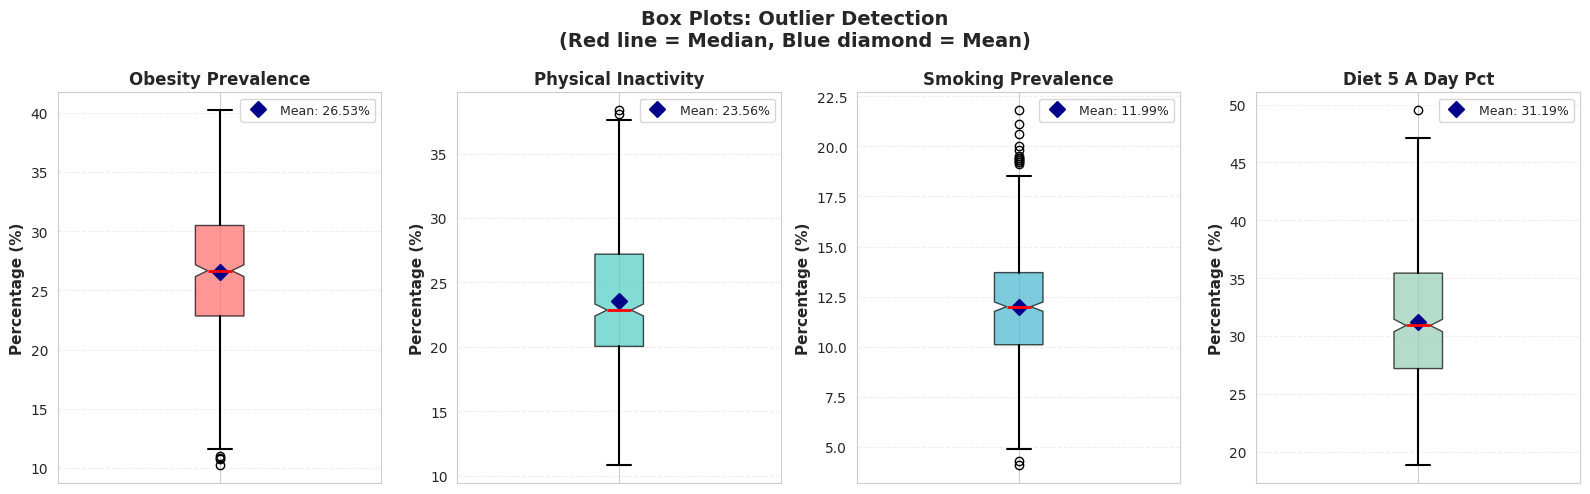

In [55]:

# VISUALIZATION 2: BOX PLOTS (OUTLIER DETECTION)

# # Purpose: Identify outliers and show data spread
# Shows: Median, quartiles (25%, 75%), and outliers

print("\n📦 Creating box plots for outlier detection...")

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for i, (var, color) in enumerate(zip(variables, colors)):
    ax = axes[i]

    # Create box plot
    bp = ax.boxplot(df[var], patch_artist=True, notch=True,
                    boxprops=dict(facecolor=color, alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))

    # Add mean marker
    mean_val = df[var].mean()
    ax.plot(1, mean_val, 'D', color='darkblue', markersize=8, label=f'Mean: {mean_val:.2f}%')

    # Labels
    ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    ax.set_title(var.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_xticklabels([''])
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Box Plots: Outlier Detection\n(Red line = Median, Blue diamond = Mean)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('2_boxplots_outliers.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: 2_boxplots_outliers.png")
plt.show()



🎻 Creating violin plots...
   ✓ Saved: 3_violin_plots.png


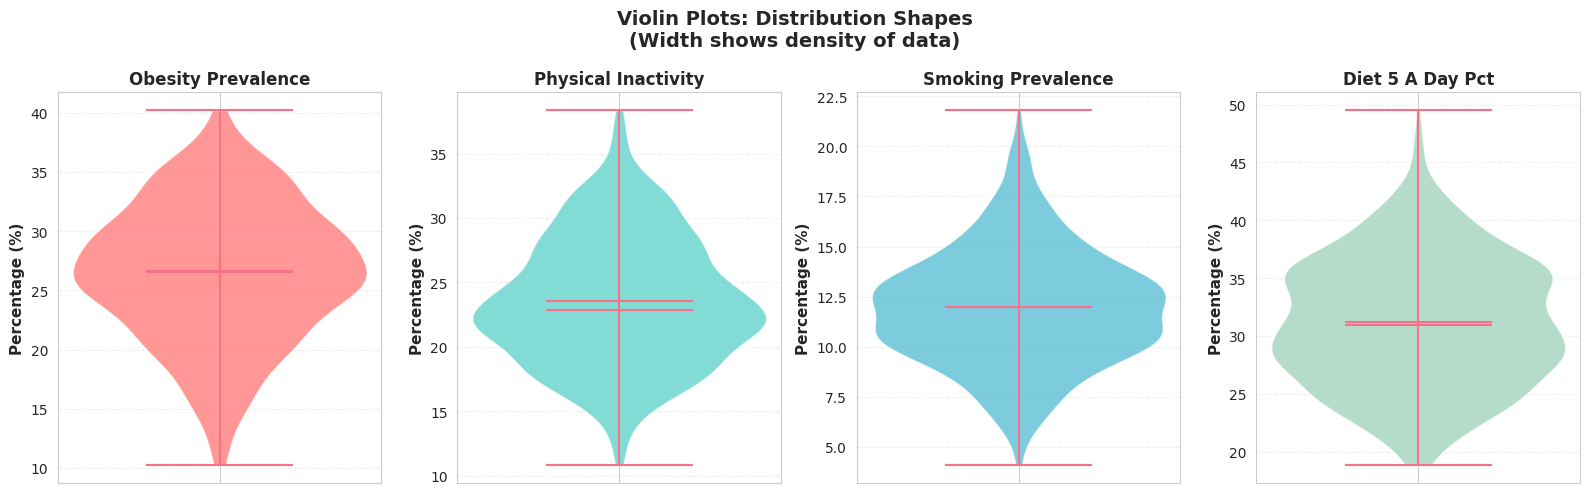

In [56]:
# VISUALIZATION 3: VIOLIN PLOTS (DISTRIBUTION SHAPE)

# Purpose: Combine box plot and distribution in one view
# Shows: Full distribution shape + quartiles

print("\n🎻 Creating violin plots...")

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for i, (var, color) in enumerate(zip(variables, colors)):
    ax = axes[i]

    # Create violin plot
    parts = ax.violinplot([df[var]], positions=[1], widths=0.7,
                          showmeans=True, showmedians=True)

    # Color the violin
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

    # Labels
    ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    ax.set_title(var.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_xticks([1])
    ax.set_xticklabels([''])
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Violin Plots: Distribution Shapes\n(Width shows density of data)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('3_violin_plots.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: 3_violin_plots.png")
plt.show()



📅 Creating temporal trend analysis...
   ✓ Saved: 4_temporal_trends.png


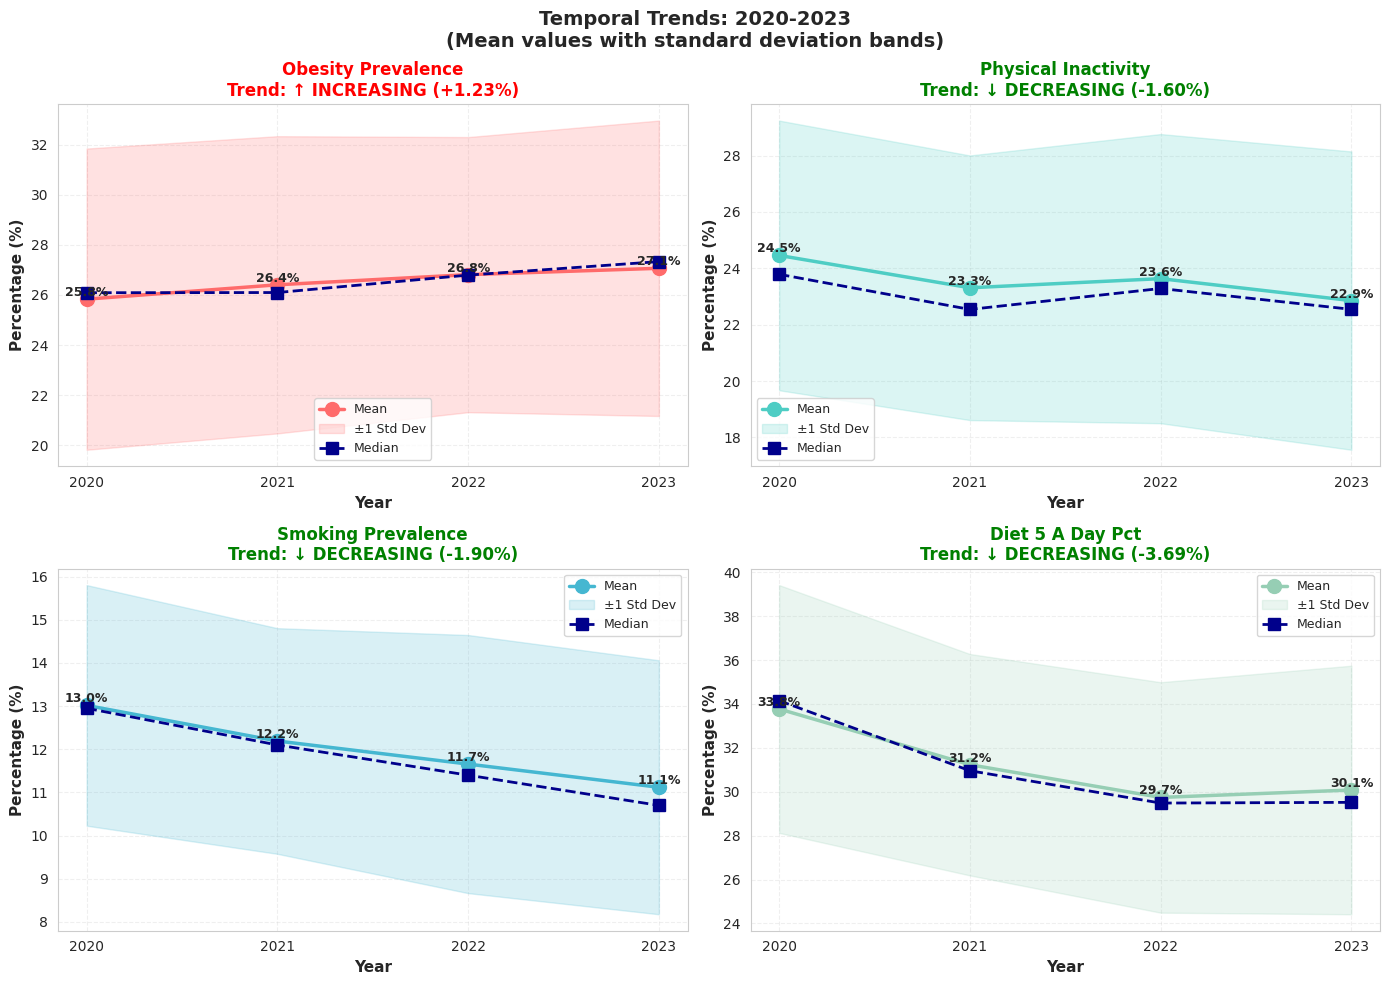

In [57]:

# VISUALIZATION 4: TEMPORAL TRENDS (YEAR-OVER-YEAR)

# Purpose: Understand how indicators changed from 2020-2023
# Shows: Trends over time, whether indicators are improving or worsening

print("\n📅 Creating temporal trend analysis...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

years = sorted(df['year'].unique())

for i, (var, color) in enumerate(zip(variables, colors)):
    ax = axes[i]

    # Calculate yearly statistics
    yearly_mean = df.groupby('year')[var].mean()
    yearly_std = df.groupby('year')[var].std()
    yearly_median = df.groupby('year')[var].median()

    # Plot mean with confidence interval
    ax.plot(years, yearly_mean, marker='o', linewidth=2.5, markersize=10,
            color=color, label='Mean')
    ax.fill_between(years,
                     yearly_mean - yearly_std,
                     yearly_mean + yearly_std,
                     alpha=0.2, color=color, label='±1 Std Dev')

    # Plot median
    ax.plot(years, yearly_median, marker='s', linewidth=2, markersize=8,
            color='darkblue', linestyle='--', label='Median')

    # Add value labels on points
    for year, mean in zip(years, yearly_mean):
        ax.text(year, mean, f'{mean:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Calculate trend direction
    if yearly_mean.iloc[-1] > yearly_mean.iloc[0]:
        trend = "↑ INCREASING"
        trend_color = 'red'
    else:
        trend = "↓ DECREASING"
        trend_color = 'green'

    change = yearly_mean.iloc[-1] - yearly_mean.iloc[0]

    # Labels
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'{var.replace("_", " ").title()}\nTrend: {trend} ({change:+.2f}%)',
                 fontsize=12, fontweight='bold', color=trend_color)
    ax.set_xticks(years)
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3, linestyle='--')

plt.suptitle('Temporal Trends: 2020-2023\n(Mean values with standard deviation bands)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('4_temporal_trends.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: 4_temporal_trends.png")
plt.show()



🔗 Creating pairwise scatter matrix...
   ✓ Saved: 5_pairplot_matrix.png


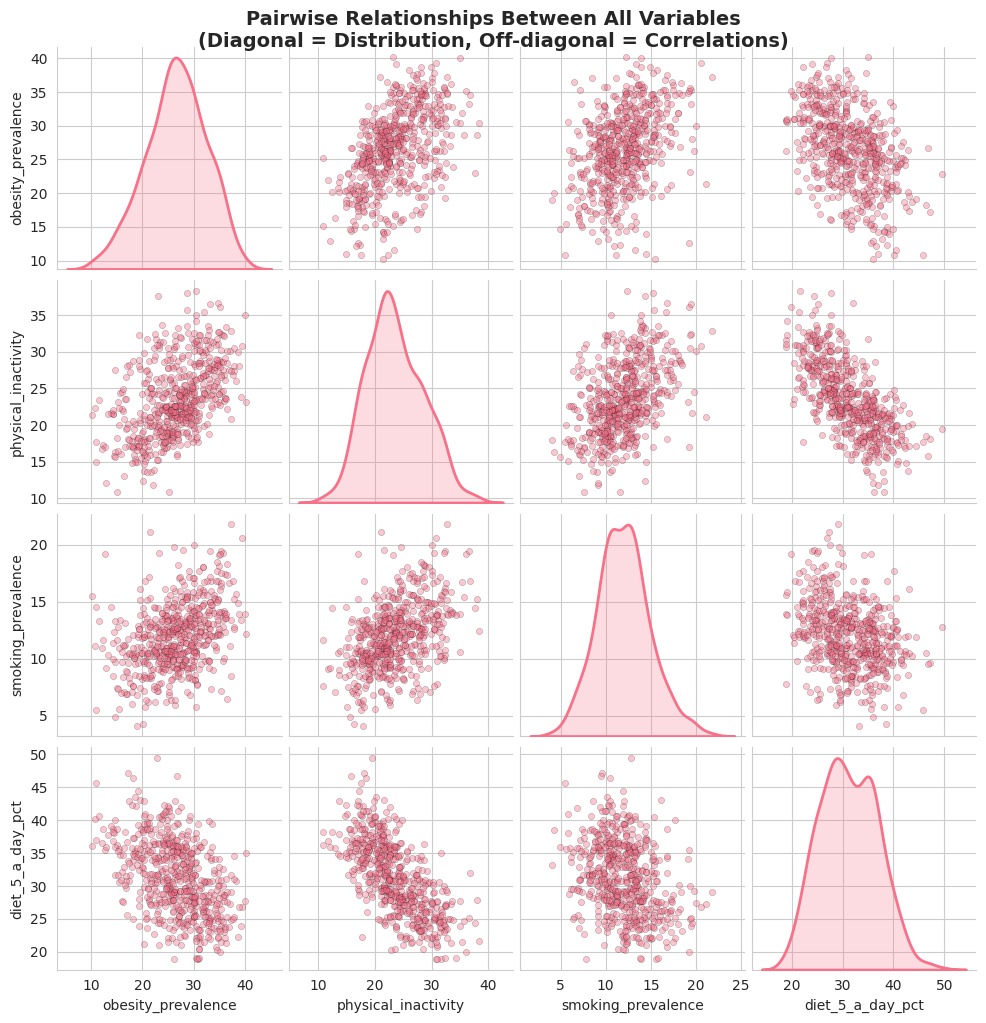


DISTRIBUTION CHARACTERISTICS SUMMARY

           Variable   Mean Median Std Dev    CV Skewness     Shape
 obesity_prevalence 26.53% 26.66%   5.84% 22.0%   -0.231 Symmetric
physical_inactivity 23.56% 22.85%   5.00% 21.2%    0.286 Symmetric
 smoking_prevalence 11.99% 12.00%   2.92% 24.3%    0.292 Symmetric
   diet_5_a_day_pct 31.19% 30.91%   5.62% 18.0%    0.178 Symmetric

✅ EXPLORATORY DATA ANALYSIS COMPLETE!

📁 Generated Files:
   1. 1_distributions_histograms.png - Distribution shapes
   2. 2_boxplots_outliers.png - Outlier detection
   3. 3_violin_plots.png - Combined distribution + box plots
   4. 4_temporal_trends.png - Year-over-year changes
   5. 5_pairplot_matrix.png - All pairwise relationships


In [58]:

# VISUALIZATION 5: PAIRWISE SCATTER MATRIX

# Purpose: See ALL relationships between variables at once
# Shows: Correlations and distribution patterns

print("\n🔗 Creating pairwise scatter matrix...")

# Select variables for pair plot
plot_vars = ['obesity_prevalence', 'physical_inactivity',
             'smoking_prevalence', 'diet_5_a_day_pct']

# Create pair plot
g = sns.pairplot(df[plot_vars],
                 diag_kind='kde',           # Diagonal: density plots
                 plot_kws={'alpha': 0.4,    # Scatter plot transparency
                          's': 20,          # Point size
                          'edgecolor': 'black',
                          'linewidth': 0.3},
                 diag_kws={'linewidth': 2})

g.fig.suptitle('Pairwise Relationships Between All Variables\n(Diagonal = Distribution, Off-diagonal = Correlations)',
               fontsize=14, fontweight='bold', y=1.02)

plt.savefig('5_pairplot_matrix.png', dpi=300, bbox_inches='tight')
print("   ✓ Saved: 5_pairplot_matrix.png")
plt.show()


# SUMMARY STATISTICS TABLE

print("\n" + "="*70)
print("DISTRIBUTION CHARACTERISTICS SUMMARY")
print("="*70)

summary_stats = []
for var in variables:
    from scipy import stats as sp_stats

    # Calculate statistics
    mean = df[var].mean()
    median = df[var].median()
    std = df[var].std()
    skewness = sp_stats.skew(df[var])
    kurtosis = sp_stats.kurtosis(df[var])
    cv = (std / mean) * 100  # Coefficient of variation

    # Determine distribution shape
    if abs(skewness) < 0.5:
        shape = "Symmetric"
    elif skewness > 0:
        shape = "Right-skewed"
    else:
        shape = "Left-skewed"

    summary_stats.append({
        'Variable': var,
        'Mean': f'{mean:.2f}%',
        'Median': f'{median:.2f}%',
        'Std Dev': f'{std:.2f}%',
        'CV': f'{cv:.1f}%',
        'Skewness': f'{skewness:.3f}',
        'Shape': shape
    })

summary_df = pd.DataFrame(summary_stats)
print("\n" + summary_df.to_string(index=False))

print("\n✅ EXPLORATORY DATA ANALYSIS COMPLETE!")
print("\n📁 Generated Files:")
print("   1. 1_distributions_histograms.png - Distribution shapes")
print("   2. 2_boxplots_outliers.png - Outlier detection")
print("   3. 3_violin_plots.png - Combined distribution + box plots")
print("   4. 4_temporal_trends.png - Year-over-year changes")
print("   5. 5_pairplot_matrix.png - All pairwise relationships")

# 5. CORRELATION ANALYSIS

CORRELATION ANALYSIS

Correlation Matrix:
                     obesity_prevalence  physical_inactivity  \
obesity_prevalence                1.000                0.495   
physical_inactivity               0.495                1.000   
smoking_prevalence                0.390                0.452   
diet_5_a_day_pct                 -0.464               -0.681   

                     smoking_prevalence  diet_5_a_day_pct  
obesity_prevalence                0.390            -0.464  
physical_inactivity               0.452            -0.681  
smoking_prevalence                1.000            -0.320  
diet_5_a_day_pct                 -0.320             1.000  

Correlations with Obesity (Target Variable):
--------------------------------------------------
   physical_inactivity           : +0.495 (MODERATE positive)
   smoking_prevalence            : +0.390 (WEAK positive)
   diet_5_a_day_pct              : -0.464 (MODERATE negative)

Saved: correlation_heatmap.png


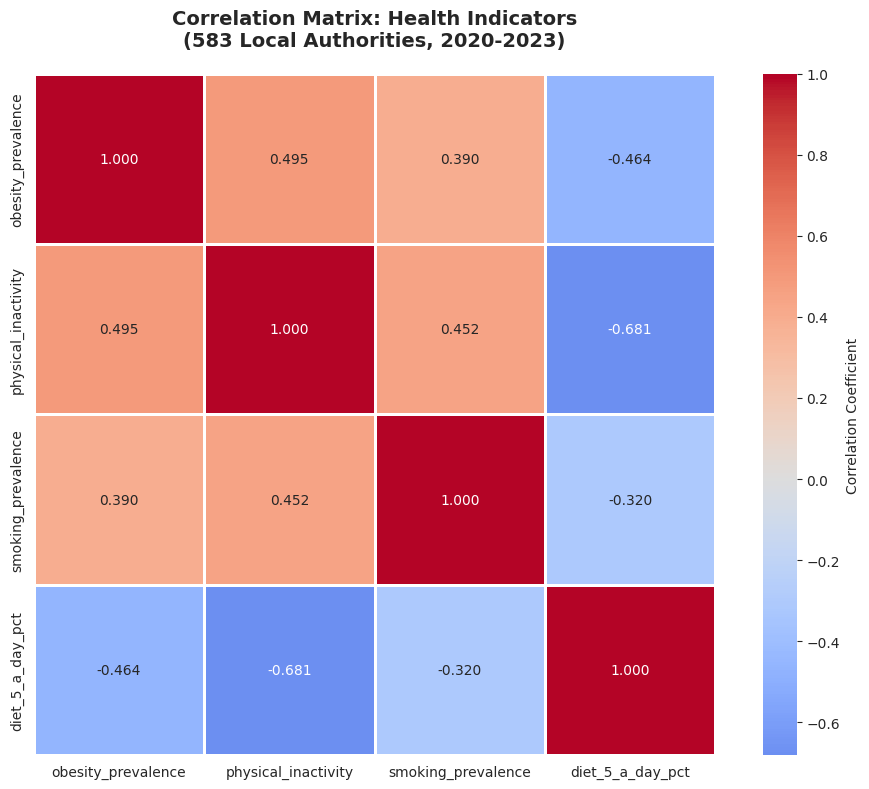


CORRELATION ANALYSIS COMPLETE!

KEY FINDINGS (RQ1):
   - Physical inactivity shows the strongest association
   - Diet (5-a-day) shows protective effect (negative correlation)
   - Smoking shows weakest association among the three predictors


In [59]:
# This cell examines relationships between variables to answer RQ1:
# "Which health behaviors are most strongly associated with obesity?"

import numpy as np

print("="*70)
print("CORRELATION ANALYSIS")
print("="*70)

# ---- Select health indicator variables ----
health_vars = ['obesity_prevalence', 'physical_inactivity',
               'smoking_prevalence', 'diet_5_a_day_pct']

# ---- Calculate correlation matrix ----
# Pearson correlation measures linear relationships between variables
# Values range from -1 (perfect negative) to +1 (perfect positive)
corr_matrix = df[health_vars].corr()

print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

# ---- Focus on correlations with obesity (target variable) ----
print("\nCorrelations with Obesity (Target Variable):")
print("-" * 50)
obesity_corr = corr_matrix['obesity_prevalence'].sort_values(ascending=False)

for var, corr_value in obesity_corr.items():
    if var != 'obesity_prevalence':
        # Interpret the strength of correlation
        if abs(corr_value) > 0.7:
            strength = "STRONG"
        elif abs(corr_value) > 0.4:
            strength = "MODERATE"
        elif abs(corr_value) > 0.2:
            strength = "WEAK"
        else:
            strength = "VERY WEAK"

        direction = "positive" if corr_value > 0 else "negative"
        print(f"   {var:30s}: {corr_value:+.3f} ({strength} {direction})")

# ---- Create correlation heatmap ----
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix,
            annot=True,           # Show correlation values
            fmt='.3f',            # Format to 3 decimal places
            cmap='coolwarm',      # Red=positive, Blue=negative
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=1,         # Add gridlines
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix: Health Indicators\n(583 Local Authorities, 2020-2023)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("\nSaved: correlation_heatmap.png")
plt.show()

print("\nCORRELATION ANALYSIS COMPLETE!")
print("\nKEY FINDINGS (RQ1):")
print("   - Physical inactivity shows the strongest association")
print("   - Diet (5-a-day) shows protective effect (negative correlation)")
print("   - Smoking shows weakest association among the three predictors")

# 6. SCATTER PLOTS - VISUALIZING RELATIONSHIPS

SCATTER PLOTS: PREDICTORS vs OBESITY

💾 Scatter plots saved as 'scatter_plots_obesity_predictors.png'


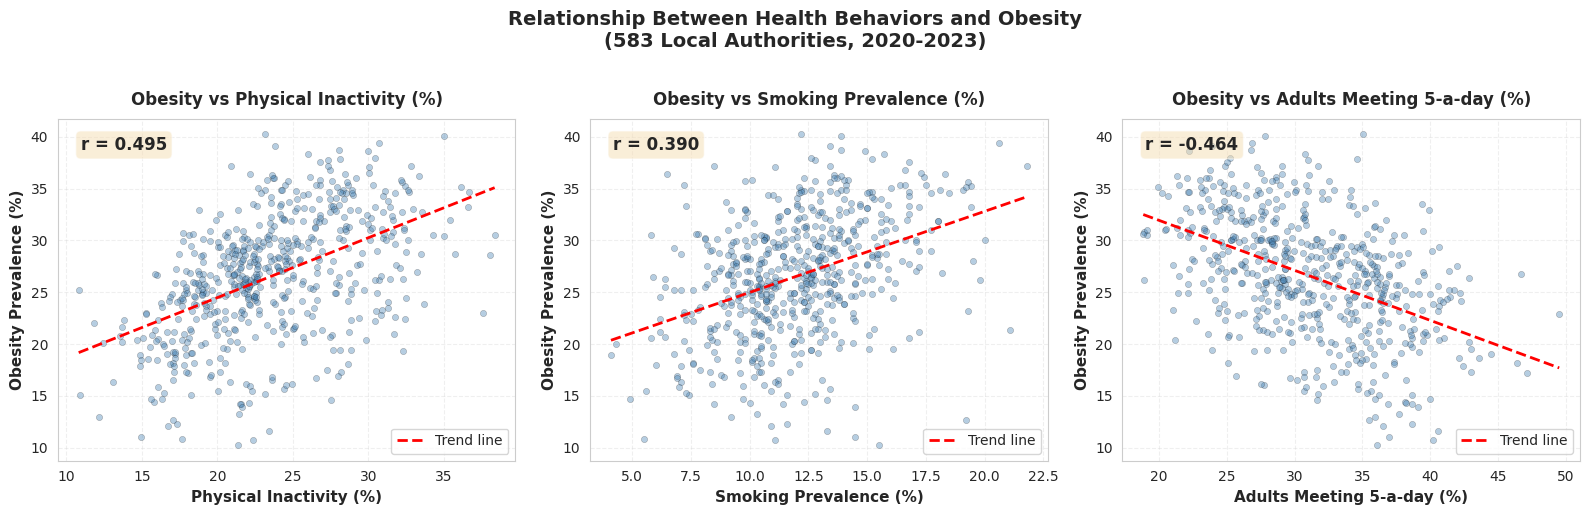


✅ SCATTER PLOTS COMPLETE!

📝 INTERPRETATION:
   - Positive slope = higher predictor → higher obesity
   - Negative slope = higher predictor → lower obesity
   - Steeper slope = stronger relationship


In [60]:
# CELL 5: SCATTER PLOTS - VISUALIZING RELATIONSHIPS
# This cell creates scatter plots showing the relationship between
# each predictor variable and obesity prevalence

import numpy as np

print("="*70)
print("SCATTER PLOTS: PREDICTORS vs OBESITY")
print("="*70)

# ---- Define predictor variables ----
predictors = ['physical_inactivity', 'smoking_prevalence', 'diet_5_a_day_pct']
predictor_labels = ['Physical Inactivity (%)', 'Smoking Prevalence (%)',
                    'Adults Meeting 5-a-day (%)']

# ---- Create figure with 3 subplots (one for each predictor) ----
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ---- Loop through each predictor and create scatter plot ----
for ax, predictor, label in zip(axes, predictors, predictor_labels):

    # Create scatter plot
    ax.scatter(df[predictor], df['obesity_prevalence'],
               alpha=0.4,           # Semi-transparent points
               s=20,                # Point size
               color='steelblue',   # Point color
               edgecolors='black',  # Point outline
               linewidth=0.3)       # Outline thickness

    # Add trend line (linear regression)
    # This helps visualize the overall relationship
    z = np.polyfit(df[predictor], df['obesity_prevalence'], 1)  # Fit line
    p = np.poly1d(z)                                             # Create polynomial
    x_line = np.linspace(df[predictor].min(), df[predictor].max(), 100)
    ax.plot(x_line, p(x_line),
            color='red',
            linewidth=2,
            linestyle='--',
            label=f'Trend line')

    # Add correlation coefficient to plot
    corr = df[predictor].corr(df['obesity_prevalence'])
    ax.text(0.05, 0.95, f'r = {corr:.3f}',
            transform=ax.transAxes,
            fontsize=12,
            fontweight='bold',
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Labels and formatting
    ax.set_xlabel(label, fontsize=11, fontweight='bold')
    ax.set_ylabel('Obesity Prevalence (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'Obesity vs {label}', fontsize=12, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='lower right')

# ---- Overall title ----
fig.suptitle('Relationship Between Health Behaviors and Obesity\n(583 Local Authorities, 2020-2023)',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()

# Save the figure
plt.savefig('scatter_plots_obesity_predictors.png', dpi=300, bbox_inches='tight')
print("\n💾 Scatter plots saved as 'scatter_plots_obesity_predictors.png'")

plt.show()

print("\n✅ SCATTER PLOTS COMPLETE!")
print("\n📝 INTERPRETATION:")
print("   - Positive slope = higher predictor → higher obesity")
print("   - Negative slope = higher predictor → lower obesity")
print("   - Steeper slope = stronger relationship")

# 7a. MACHINE LEARNING - DATA PREPARATION

In [61]:

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("="*70)
print("MACHINE LEARNING - DATA PREPARATION")
print("="*70)

# Define features and target
feature_cols = ['physical_inactivity', 'smoking_prevalence', 'diet_5_a_day_pct']
X = df[feature_cols].copy()
y = df['obesity_prevalence'].copy()

print(f"\nFeatures: {feature_cols}")
print(f"Target: obesity_prevalence")
print(f"Total observations: {len(X)}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {len(X_train)} observations ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} observations ({len(X_test)/len(X)*100:.1f}%)")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures standardized (mean=0, std=1)")

# Storage for results
results = {}

print("\n" + "="*70)
print("DATA PREPARATION COMPLETE!")
print("="*70)

MACHINE LEARNING - DATA PREPARATION

Features: ['physical_inactivity', 'smoking_prevalence', 'diet_5_a_day_pct']
Target: obesity_prevalence
Total observations: 583

Training set: 466 observations (79.9%)
Test set: 117 observations (20.1%)

Features standardized (mean=0, std=1)

DATA PREPARATION COMPLETE!


# 7b. # LASSO REGRESSION MODEL + VISUALIZATION

MODEL 1: LASSO REGRESSION

Training Lasso Regression...
   Model trained!

Performance:
   R² Score: 0.3493 (34.93% variance explained)
   RMSE: 5.03 percentage points
   MAE: 3.96 percentage points

   Cross-Validation R²: 0.2741 (±0.0656)

Feature Coefficients:
   physical_inactivity           : +1.5399
   smoking_prevalence            : +0.9282
   diet_5_a_day_pct              : -1.1398

Saved: model_1_lasso_regression.png


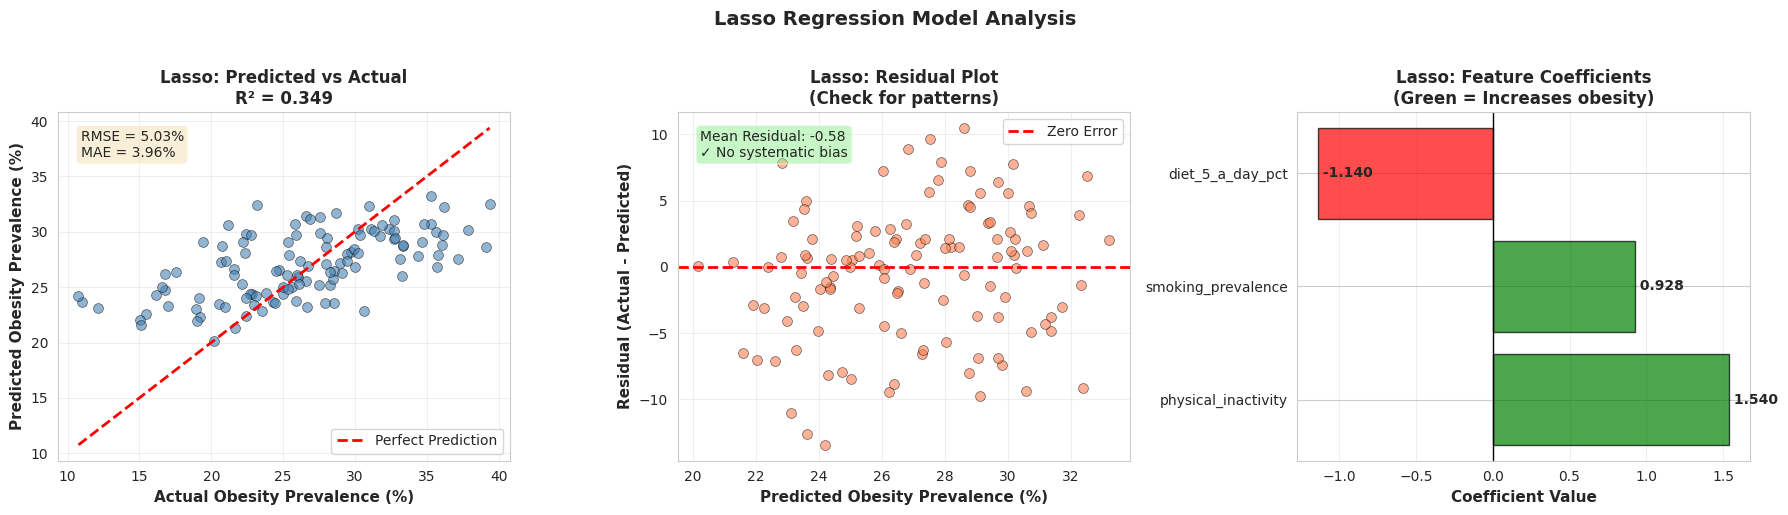


LASSO REGRESSION COMPLETE!


In [62]:

from sklearn.linear_model import Lasso
import numpy as np

print("="*70)
print("MODEL 1: LASSO REGRESSION")
print("="*70)

# Train model
print("\nTraining Lasso Regression...")
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_scaled, y_train)
print("   Model trained!")

# Predictions
y_pred_lasso = lasso.predict(X_test_scaled)

# Metrics
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print(f"\nPerformance:")
print(f"   R² Score: {r2_lasso:.4f} ({r2_lasso*100:.2f}% variance explained)")
print(f"   RMSE: {rmse_lasso:.2f} percentage points")
print(f"   MAE: {mae_lasso:.2f} percentage points")

# Cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=kfold, scoring='r2')
print(f"\n   Cross-Validation R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Feature coefficients
print(f"\nFeature Coefficients:")
for feature, coef in zip(feature_cols, lasso.coef_):
    print(f"   {feature:30s}: {coef:+.4f}")

# ============================================================
# VISUALIZATION: LASSO REGRESSION
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- PLOT 1: Predicted vs Actual ----
ax1 = axes[0]

# Scatter plot of predictions vs actual values
ax1.scatter(y_test, y_pred_lasso, alpha=0.6, s=50,
           edgecolors='black', linewidth=0.5, color='steelblue')

# Perfect prediction line (45-degree line)
min_val = min(y_test.min(), y_pred_lasso.min())
max_val = max(y_test.max(), y_pred_lasso.max())
ax1.plot([min_val, max_val], [min_val, max_val],
         'r--', linewidth=2, label='Perfect Prediction')

# Labels
ax1.set_xlabel('Actual Obesity Prevalence (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Obesity Prevalence (%)', fontsize=11, fontweight='bold')
ax1.set_title(f'Lasso: Predicted vs Actual\nR² = {r2_lasso:.3f}',
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Add text box with metrics
textstr = f'RMSE = {rmse_lasso:.2f}%\nMAE = {mae_lasso:.2f}%'
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ---- PLOT 2: Residuals (Prediction Errors) ----
ax2 = axes[1]

# Calculate residuals (errors)
residuals = y_test - y_pred_lasso

# Scatter plot of residuals
ax2.scatter(y_pred_lasso, residuals, alpha=0.6, s=50,
           edgecolors='black', linewidth=0.5, color='coral')

# Zero line (perfect predictions)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

# Labels
ax2.set_xlabel('Predicted Obesity Prevalence (%)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
ax2.set_title('Lasso: Residual Plot\n(Check for patterns)',
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Interpretation note
if abs(residuals.mean()) < 1:
    pattern = "✓ No systematic bias"
else:
    pattern = "⚠ May have bias"
ax2.text(0.05, 0.95, f'Mean Residual: {residuals.mean():.2f}\n{pattern}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# ---- PLOT 3: Feature Coefficients ----
ax3 = axes[2]

# Bar plot of coefficients
colors = ['green' if c > 0 else 'red' for c in lasso.coef_]
bars = ax3.barh(feature_cols, lasso.coef_, color=colors, alpha=0.7,
                edgecolor='black', linewidth=1)

# Zero line
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)

# Labels
ax3.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax3.set_title('Lasso: Feature Coefficients\n(Green = Increases obesity)',
              fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Add value labels
for i, (feature, coef) in enumerate(zip(feature_cols, lasso.coef_)):
    ax3.text(coef, i, f' {coef:.3f}', va='center', fontweight='bold')

plt.suptitle('Lasso Regression Model Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_1_lasso_regression.png', dpi=300, bbox_inches='tight')
print("\nSaved: model_1_lasso_regression.png")
plt.show()

# Store results
results['Lasso Regression'] = {
    'model': lasso,
    'y_pred': y_pred_lasso,
    'R2_test': r2_lasso,
    'RMSE_test': rmse_lasso,
    'MAE_test': mae_lasso,
    'CV_R2_mean': cv_scores.mean(),
    'CV_R2_std': cv_scores.std()
}

print("\n" + "="*70)
print("LASSO REGRESSION COMPLETE!")
print("="*70)

# 7c. RIDGE REGRESSION MODEL + VISUALIZATION

MODEL 2: RIDGE REGRESSION

Training Ridge Regression...
   Model trained!

Performance:
   R² Score: 0.3551 (35.51% variance explained)
   RMSE: 5.01 percentage points
   MAE: 3.94 percentage points

   Cross-Validation R²: 0.2747 (±0.0682)

Comparison with Lasso:
   Lasso R²:  0.3493
   Ridge R²:  0.3551
   → Ridge is BETTER by 0.0058

Feature Coefficients:
   physical_inactivity           : +1.5674
   smoking_prevalence            : +0.9955
   diet_5_a_day_pct              : -1.1975

Saved: model_2_ridge_regression.png


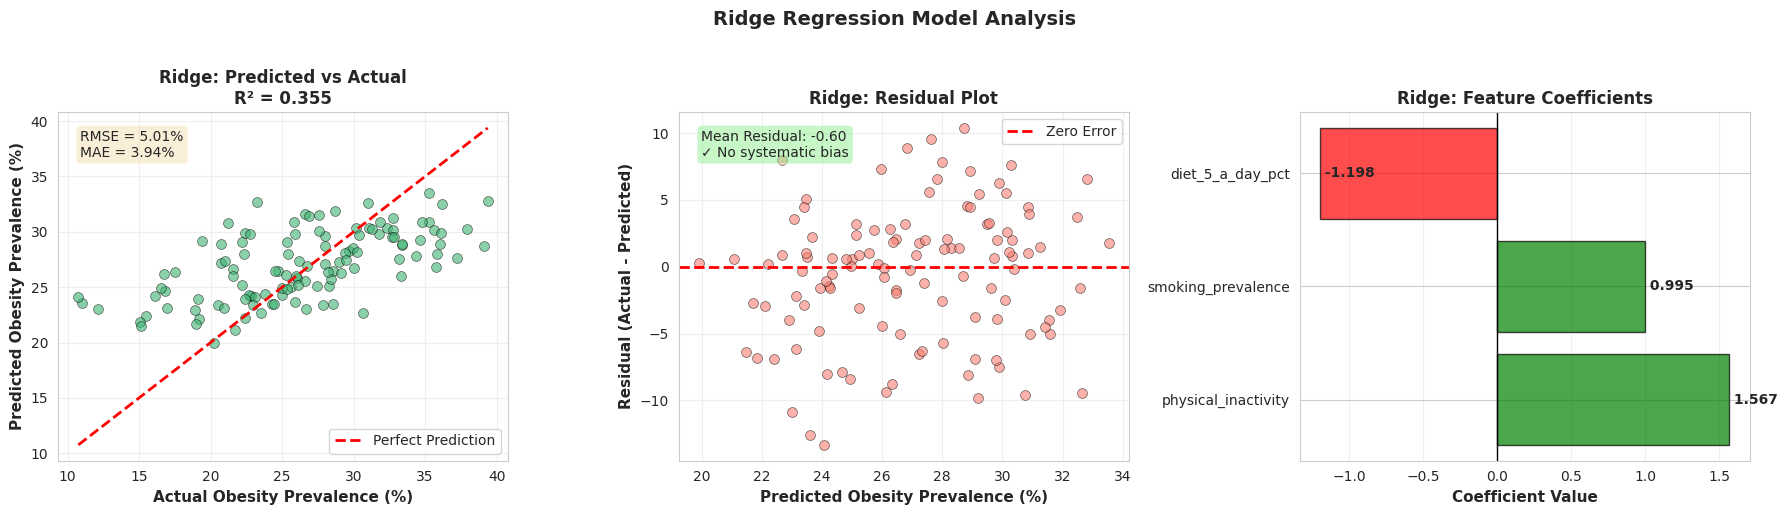


RIDGE REGRESSION COMPLETE!


In [63]:
from sklearn.linear_model import Ridge

print("="*70)
print("MODEL 2: RIDGE REGRESSION")
print("="*70)

# Train model
print("\nTraining Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
print("   Model trained!")

# Predictions
y_pred_ridge = ridge.predict(X_test_scaled)

# Metrics
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"\nPerformance:")
print(f"   R² Score: {r2_ridge:.4f} ({r2_ridge*100:.2f}% variance explained)")
print(f"   RMSE: {rmse_ridge:.2f} percentage points")
print(f"   MAE: {mae_ridge:.2f} percentage points")

# Cross-validation
cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=kfold, scoring='r2')
print(f"\n   Cross-Validation R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Compare with Lasso
print(f"\nComparison with Lasso:")
print(f"   Lasso R²:  {results['Lasso Regression']['R2_test']:.4f}")
print(f"   Ridge R²:  {r2_ridge:.4f}")
diff = r2_ridge - results['Lasso Regression']['R2_test']
if diff > 0:
    print(f"   → Ridge is BETTER by {diff:.4f}")
else:
    print(f"   → Lasso is BETTER by {-diff:.4f}")

# Feature coefficients
print(f"\nFeature Coefficients:")
for feature, coef in zip(feature_cols, ridge.coef_):
    print(f"   {feature:30s}: {coef:+.4f}")


# VISUALIZATION: RIDGE REGRESSION

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- PLOT 1: Predicted vs Actual ----
ax1 = axes[0]
ax1.scatter(y_test, y_pred_ridge, alpha=0.6, s=50,
           edgecolors='black', linewidth=0.5, color='mediumseagreen')

min_val = min(y_test.min(), y_pred_ridge.min())
max_val = max(y_test.max(), y_pred_ridge.max())
ax1.plot([min_val, max_val], [min_val, max_val],
         'r--', linewidth=2, label='Perfect Prediction')

ax1.set_xlabel('Actual Obesity Prevalence (%)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted Obesity Prevalence (%)', fontsize=11, fontweight='bold')
ax1.set_title(f'Ridge: Predicted vs Actual\nR² = {r2_ridge:.3f}',
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

textstr = f'RMSE = {rmse_ridge:.2f}%\nMAE = {mae_ridge:.2f}%'
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ---- PLOT 2: Residuals ----
ax2 = axes[1]
residuals = y_test - y_pred_ridge

ax2.scatter(y_pred_ridge, residuals, alpha=0.6, s=50,
           edgecolors='black', linewidth=0.5, color='salmon')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')

ax2.set_xlabel('Predicted Obesity Prevalence (%)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Residual (Actual - Predicted)', fontsize=11, fontweight='bold')
ax2.set_title('Ridge: Residual Plot', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

pattern = "✓ No systematic bias" if abs(residuals.mean()) < 1 else "⚠ May have bias"
ax2.text(0.05, 0.95, f'Mean Residual: {residuals.mean():.2f}\n{pattern}',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# ---- PLOT 3: Feature Coefficients ----
ax3 = axes[2]
colors = ['green' if c > 0 else 'red' for c in ridge.coef_]
bars = ax3.barh(feature_cols, ridge.coef_, color=colors, alpha=0.7,
                edgecolor='black', linewidth=1)

ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Coefficient Value', fontsize=11, fontweight='bold')
ax3.set_title('Ridge: Feature Coefficients', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

for i, (feature, coef) in enumerate(zip(feature_cols, ridge.coef_)):
    ax3.text(coef, i, f' {coef:.3f}', va='center', fontweight='bold')

plt.suptitle('Ridge Regression Model Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_2_ridge_regression.png', dpi=300, bbox_inches='tight')
print("\nSaved: model_2_ridge_regression.png")
plt.show()

# Store results
results['Ridge Regression'] = {
    'model': ridge,
    'y_pred': y_pred_ridge,
    'R2_test': r2_ridge,
    'RMSE_test': rmse_ridge,
    'MAE_test': mae_ridge,
    'CV_R2_mean': cv_scores.mean(),
    'CV_R2_std': cv_scores.std()
}

print("\n" + "="*70)
print("RIDGE REGRESSION COMPLETE!")
print("="*70)